# 1. Load Libraries

In [2]:
# Load necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer

# 2. Load Files

In [4]:
# Loading the dataset

# Double Line Remove

csv_file_path = 'canada_rent.csv'
df = pd.read_csv(csv_file_path, header=None)

# Define column names
df.columns = ['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude', 
              'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'link', 
              'furnishing', 'availability_date', 'smoking', 'cats', 'dogs']

# Gather initial information
print(df.head())

   rentfaster_id     city  province           address    latitude  \
0  rentfaster_id     city  province           address    latitude   
1         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   
2         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   
3         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   
4         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   

     longitude  lease_term       type  price    beds  baths  sq_feet  \
0    longitude  lease_term       type  price    beds  baths  sq_feet   
1  -114.012515   Long Term  Townhouse   2495  2 Beds    2.5     1403   
2  -114.012515   Long Term  Townhouse   2695  3 Beds    2.5     1496   
3  -114.012515   Long Term  Townhouse   2295  2 Beds    2.5     1180   
4  -114.012515   Long Term  Townhouse   2095  2 Beds    2.5     1403   

                                                link   furnishing  \
0                                               link   furnishing   
1  /ab/airdrie

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25772 entries, 0 to 25771
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rentfaster_id      25772 non-null  object
 1   city               25772 non-null  object
 2   province           25772 non-null  object
 3   address            25647 non-null  object
 4   latitude           25772 non-null  object
 5   longitude          25772 non-null  object
 6   lease_term         25726 non-null  object
 7   type               25772 non-null  object
 8   price              25772 non-null  object
 9   beds               25640 non-null  object
 10  baths              25638 non-null  object
 11  sq_feet            21660 non-null  object
 12  link               25772 non-null  object
 13  furnishing         25772 non-null  object
 14  availability_date  25760 non-null  object
 15  smoking            23070 non-null  object
 16  cats               25599 non-null  objec

# 3. Data Cleaning and Preprocessing

In [7]:
# Remove the first row since it contains dupliocate headers

df = df[1:].reset_index(drop=True)

In [8]:
# Convert data types

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')
df['beds'] = df['beds'].str.extract(r'(\d+)').astype(float)
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')
df['cats'] = df['cats'].astype(bool)
df['dogs'] = df['dogs'].astype(bool)

In [9]:
# Handle missing values
categorical_cols = ['address', 'lease_term', 'furnishing', 'smoking', 'availability_date']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

numeric_cols = ['price', 'sq_feet', 'beds', 'baths']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [10]:
# Define a function to handle different cases in 'availability_date'

def parse_availability_date(value):
    value_str = str(value)
    if value_str.lower() == 'immediate':
        return pd.Timestamp('2024-01-01')  # Placeholder date
    try:
        return pd.to_datetime(value_str, format='%B %d', errors='coerce')
    except ValueError:
        return pd.NaT

df['availability_date'] = df['availability_date'].apply(parse_availability_date)
df['availability_date'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

In [11]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [12]:
# Format text data. Strip leading/trailing spaces from string columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [13]:
# Handle outliers

def cap_outliers(series, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower_bound, upper_bound)

df['price'] = cap_outliers(df['price'])
df['sq_feet'] = cap_outliers(df['sq_feet'])

In [14]:
# Final verification and save to a new file
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19037 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rentfaster_id      19037 non-null  object        
 1   city               19037 non-null  object        
 2   province           19037 non-null  object        
 3   address            19037 non-null  object        
 4   latitude           19037 non-null  float64       
 5   longitude          19037 non-null  float64       
 6   lease_term         19037 non-null  object        
 7   type               19037 non-null  object        
 8   price              19037 non-null  float64       
 9   beds               19037 non-null  float64       
 10  baths              19037 non-null  float64       
 11  sq_feet            19037 non-null  float64       
 12  link               19037 non-null  object        
 13  furnishing         19037 non-null  object        
 14  availabilit

In [15]:
print(df.describe())

           latitude     longitude         price          beds         baths  \
count  19037.000000  19037.000000  19037.000000  19037.000000  19037.000000   
mean      48.441980    -97.472814   2132.745229      1.847035      1.378368   
min       40.741802   -128.661880    588.600000      1.000000      0.000000   
25%       44.607311   -114.050053   1600.000000      1.000000      1.000000   
50%       49.831810   -107.794571   2025.000000      2.000000      1.000000   
75%       51.114130    -79.374890   2550.000000      2.000000      2.000000   
max       62.459246    -52.695472   5100.000000      9.000000      8.000000   
std        3.828399     18.604327    799.456546      0.838897      0.626246   

            sq_feet              availability_date  
count  19037.000000                          19037  
mean     845.102442  1975-09-21 10:58:41.521248064  
min        0.000000            1900-01-01 00:00:00  
25%      636.000000            1900-07-15 00:00:00  
50%      800.000000    

In [16]:
df.to_csv('cleaned_canada_rent.csv', index=False)

In [17]:
# No missing values, all columns have non-null values
# Data types have been appropriately converted
# Outlier extreme values in price and sq_feet have been capped

# 4. Exploratory Data Analysis (EDA)

In [19]:
# Display the first few rows of the DataFrame

print(df.head())

  rentfaster_id     city province           address   latitude   longitude  \
0        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
1        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
2        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
3        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
6        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   

  lease_term       type   price  beds  baths  sq_feet  \
0  Long Term  Townhouse  2495.0   2.0    2.5   1403.0   
1  Long Term  Townhouse  2695.0   3.0    2.5   1496.0   
2  Long Term  Townhouse  2295.0   2.0    2.5   1180.0   
3  Long Term  Townhouse  2095.0   2.0    2.5   1403.0   
6  Long Term  Townhouse  2495.0   2.0    2.5   1351.0   

                                                link   furnishing  \
0  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
1  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f.

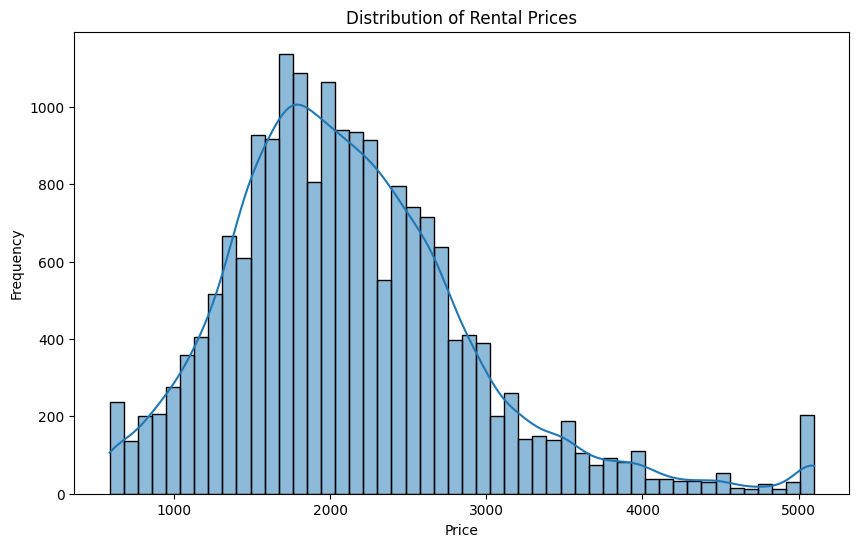

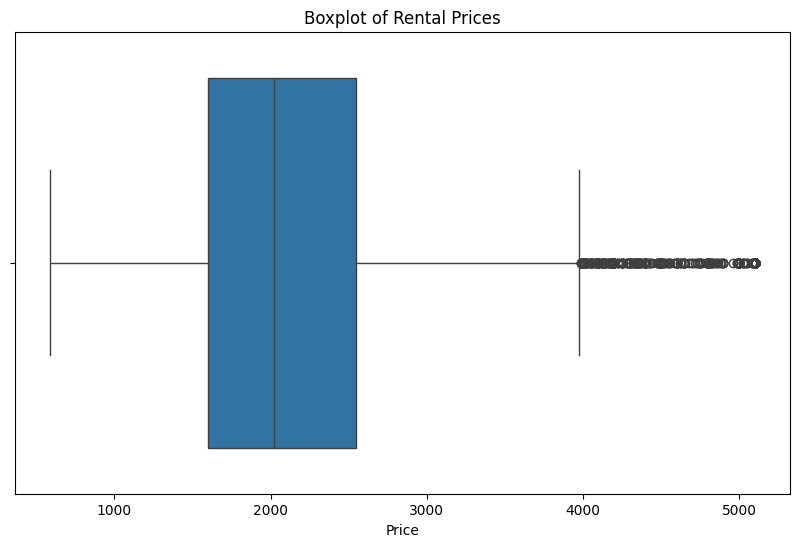

In [20]:
# Visualize the rental price distributions

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='price', data=df)
plt.title('Boxplot of Rental Prices')
plt.xlabel('Price')
plt.show()

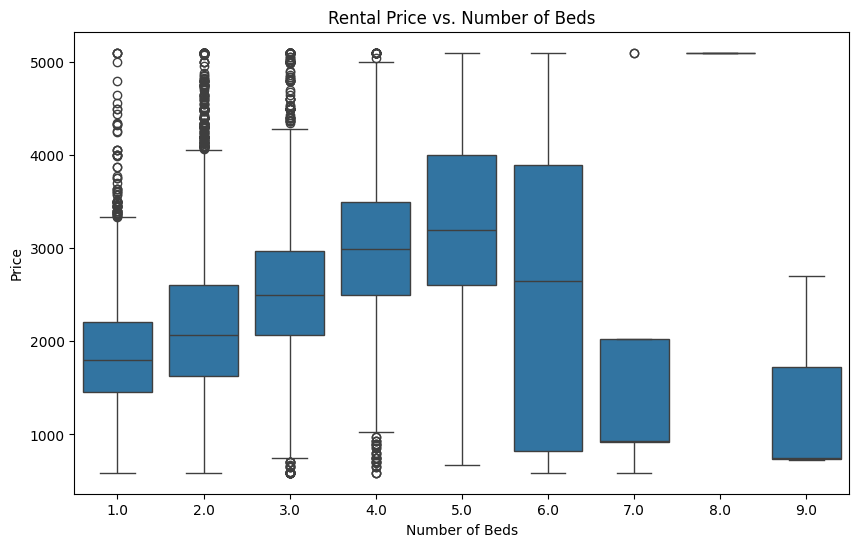

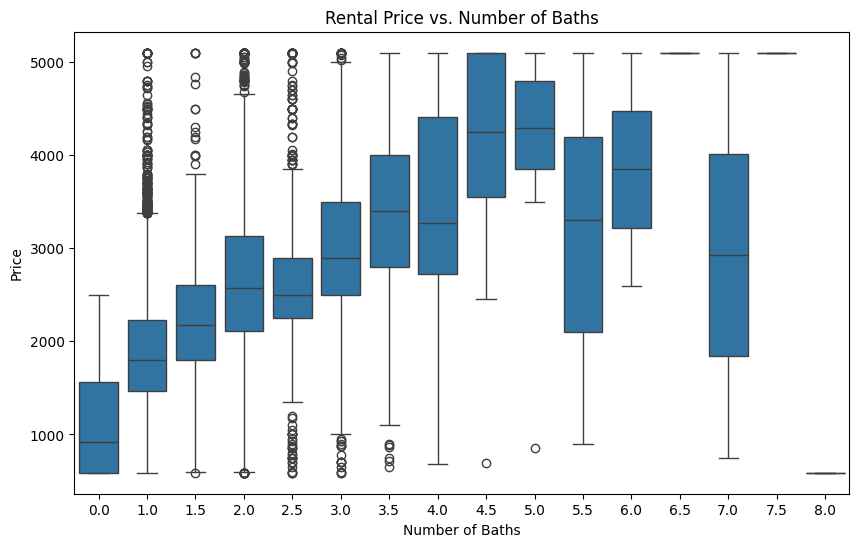

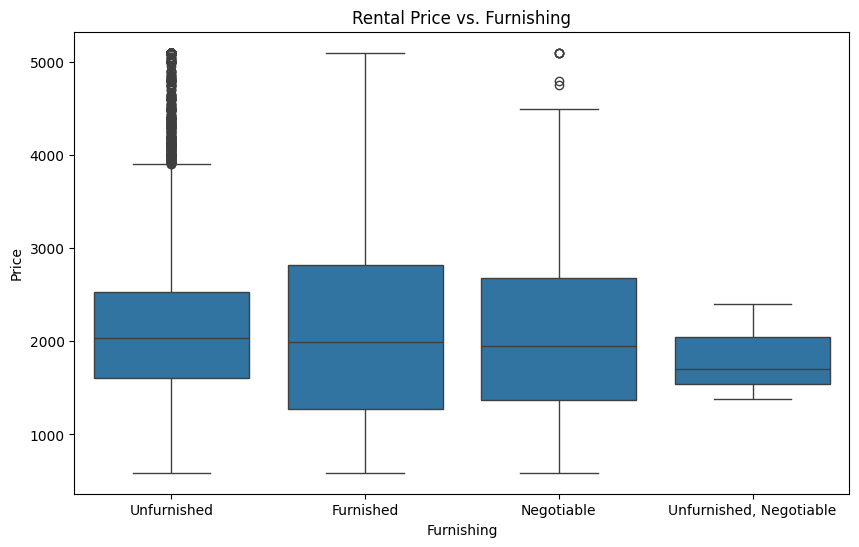

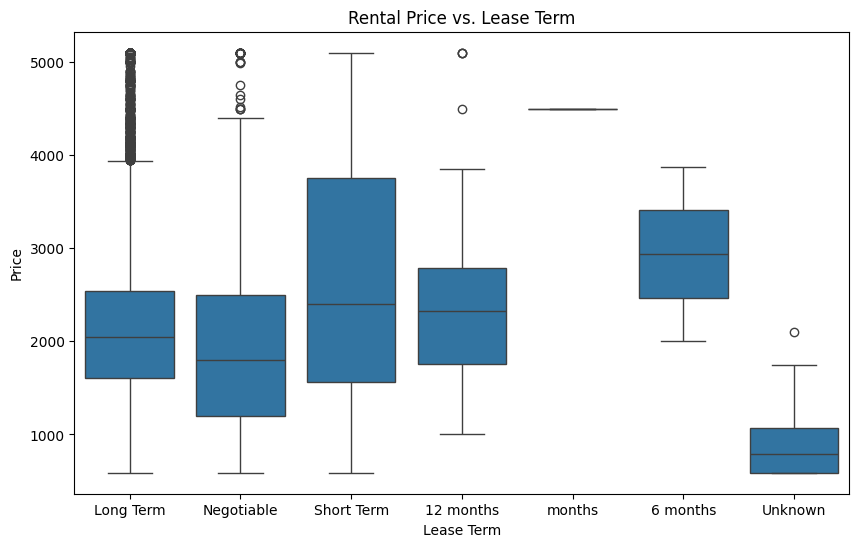

In [21]:
# Price vs. Other Features

# Price vs. number of beds
plt.figure(figsize=(10, 6))
sns.boxplot(x='beds', y='price', data=df)
plt.title('Rental Price vs. Number of Beds')
plt.xlabel('Number of Beds')
plt.ylabel('Price')
plt.show()

# Price vs. number of baths
plt.figure(figsize=(10, 6))
sns.boxplot(x='baths', y='price', data=df)
plt.title('Rental Price vs. Number of Baths')
plt.xlabel('Number of Baths')
plt.ylabel('Price')
plt.show()

# Price vs. furnishing
plt.figure(figsize=(10, 6))
sns.boxplot(x='furnishing', y='price', data=df)
plt.title('Rental Price vs. Furnishing')
plt.xlabel('Furnishing')
plt.ylabel('Price')
plt.show()

# Price vs. lease term
plt.figure(figsize=(10, 6))
sns.boxplot(x='lease_term', y='price', data=df)
plt.title('Rental Price vs. Lease Term')
plt.xlabel('Lease Term')
plt.ylabel('Price')
plt.show()

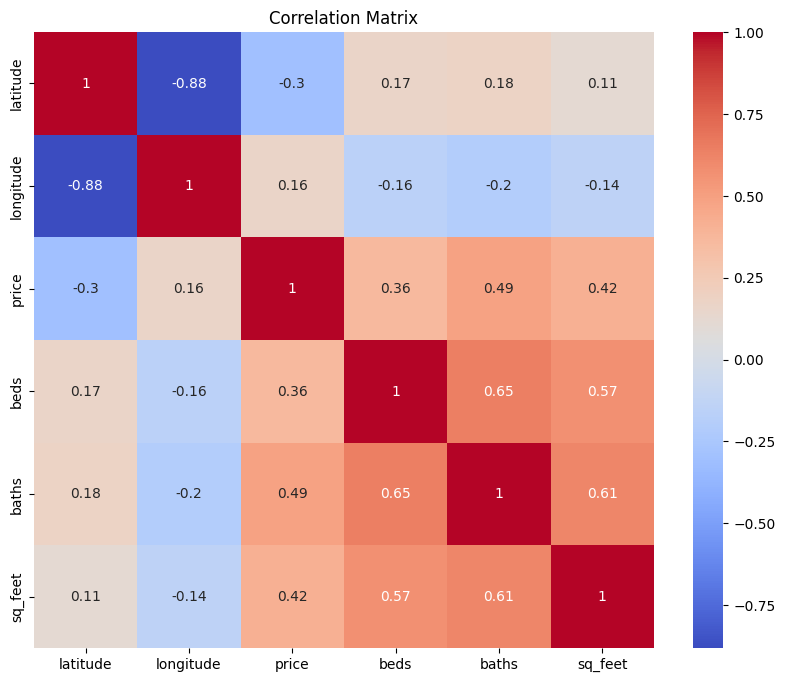

In [22]:
# Correlation Matrix
numeric_df = df.select_dtypes(include=[float, int])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

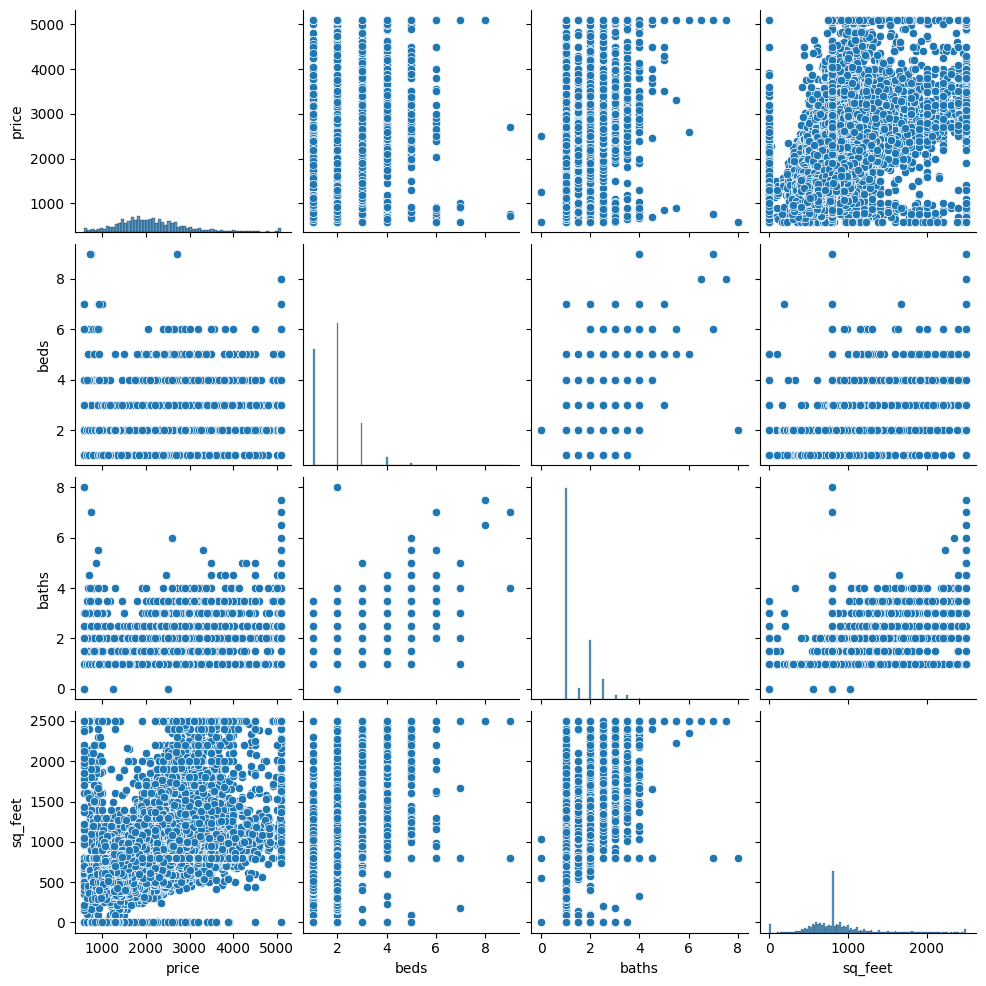

In [23]:
# Pairplot for numerical features
sns.pairplot(df[['price', 'beds', 'baths', 'sq_feet']])
plt.show()

# 5. Feature Engineering and Transformation

In [25]:
# Feature creation
# Total rooms (beds + baths)
df['total_rooms'] = df['beds'] + df['baths']

# Price per square foot (avoid division by zero)
df['price_per_sqft'] = df['price'] / df['sq_feet'].replace(0, np.nan)

In [26]:
# Extract year, month, and day from availability date

df['availability_year'] = df['availability_date'].dt.year
df['availability_month'] = df['availability_date'].dt.month
df['availability_day'] = df['availability_date'].dt.day

In [27]:
# Handle categorical data
categorical_cols = ['city', 'province', 'lease_term', 'type', 'furnishing', 'smoking']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [28]:
# Feature scaling
df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Fill NaN values in numeric columns with the mean of each column
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# For non-numeric columns, fill with mode of each column
for col in non_numeric_cols:
    df[col].fillna(df[col].mode()[0], inplace=True) 

# Identify numerical columns
numerical_cols = ['latitude', 'longitude', 'beds', 'baths', 'sq_feet', 'total_rooms', 'price_per_sqft']

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Drop the original 'availability_date' since useful features have been extracted from it
df = df.drop(columns=['availability_date'])

# Check the dataframe after feature engineering
print(df.head())

  rentfaster_id           address  latitude  longitude   price      beds  \
0        468622  69 Gateway Dr NE  0.748108  -0.889048  2495.0  0.182346   
1        468622  69 Gateway Dr NE  0.748108  -0.889048  2695.0  1.374418   
2        468622  69 Gateway Dr NE  0.748108  -0.889048  2295.0  0.182346   
3        468622  69 Gateway Dr NE  0.748108  -0.889048  2095.0  0.182346   
6        468622  69 Gateway Dr NE  0.748108  -0.889048  2495.0  0.182346   

      baths   sq_feet                                               link  \
0  1.791087  1.434011  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
1  1.791087  1.673056  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
2  1.791087  0.860815  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
3  1.791087  1.434011  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
6  1.791087  1.300351  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   

   cats  ...  type_Storage  type_Townhouse  type_Vacation Home  \
0  True  ...        

In [29]:
# Save the prepared data for modeling

df.to_csv('prepared_data.csv', index=False)

# 5. Model Comparison

In [31]:
# For categorical columns with string values (e.g., if any exist after dropping the non-numeric columns), use One-Hot Encoding

# Drop non-numeric columns (e.g., 'rentfaster_id', 'address')
df = df.drop(columns=['rentfaster_id', 'address'])

# Prepare the features and target variable
X = df.drop(columns=['price'])
y = df['price']

# Identify categorical features for one-hot encoding
categorical_features = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

X_transformed = preprocessor.fit_transform(X)

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [33]:
# Build the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

# 6. Choose a Validation Scheme

In [35]:
# Evaluate each model

# Train the models and evaluate each model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mae, rmse

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    mae, rmse = evaluate_model(model, X_test, y_test)
    print(f'{model_name}: MAE={mae}, RMSE={rmse}')

Linear Regression: MAE=286.86336476363346, RMSE=436.5963519975518
Ridge Regression: MAE=259.326862148337, RMSE=395.2807587340767
Lasso Regression: MAE=330.9158518941845, RMSE=477.6975221729699


In [36]:
# Select the best model
best_model_name = min(models.keys(), key=lambda name: evaluate_model(models[name], X_test, y_test)[0])
best_model = models[best_model_name]

print(f"Best Performance: {best_model_name}")

Best Performance: Ridge Regression


In [ ]:
# Ridge Regression has the lowest MAE and RSME, which indicates a stronger model.

# 7. Make Predictions with the Final Model

In [38]:
# Generate predictions using the best model on the training data
training_predictions = best_model.predict(X_train)

# Evaluate predictions on the training data
mse_train = mean_squared_error(y_train, training_predictions)
mae_train = mean_absolute_error(y_train, training_predictions)
rmse_train = np.sqrt(mse_train)

print(f"Training Set Evaluation: {best_model_name}")
print(f" - MSE: {mse_train}")
print(f" - MAE: {mae_train}")
print(f" - RMSE: {rmse_train}")

Training Set Evaluation: Ridge Regression
 - MSE: 65192.707800269054
 - MAE: 169.7904576795032
 - RMSE: 255.32862706768518


In [39]:
# Generate predictions using the best model on the test data
test_predictions = best_model.predict(X_test)

# Evaluate predictions on the test data
mse_test = mean_squared_error(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f"Test Set Evaluation: {best_model_name}")
print(f" - MSE: {mse_test}")
print(f" - MAE: {mae_test}")
print(f" - RMSE: {rmse_test}")

Test Set Evaluation: Ridge Regression
 - MSE: 156246.87822538734
 - MAE: 259.326862148337
 - RMSE: 395.2807587340767


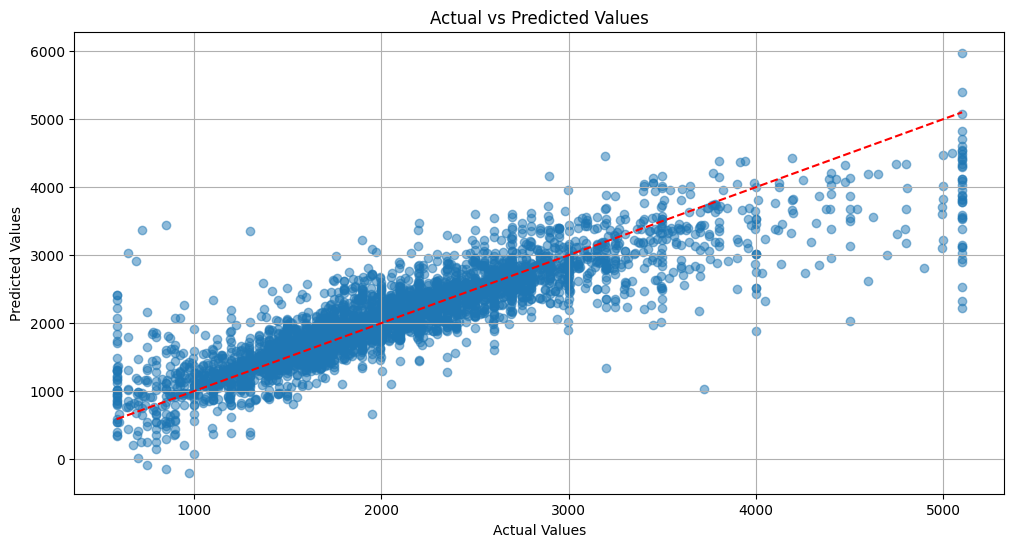

In [40]:
# Visualize Predictions vs Actual Values

plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
# Ideal line '--'
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.savefig('predicted_vs_actual.png') 
plt.show()

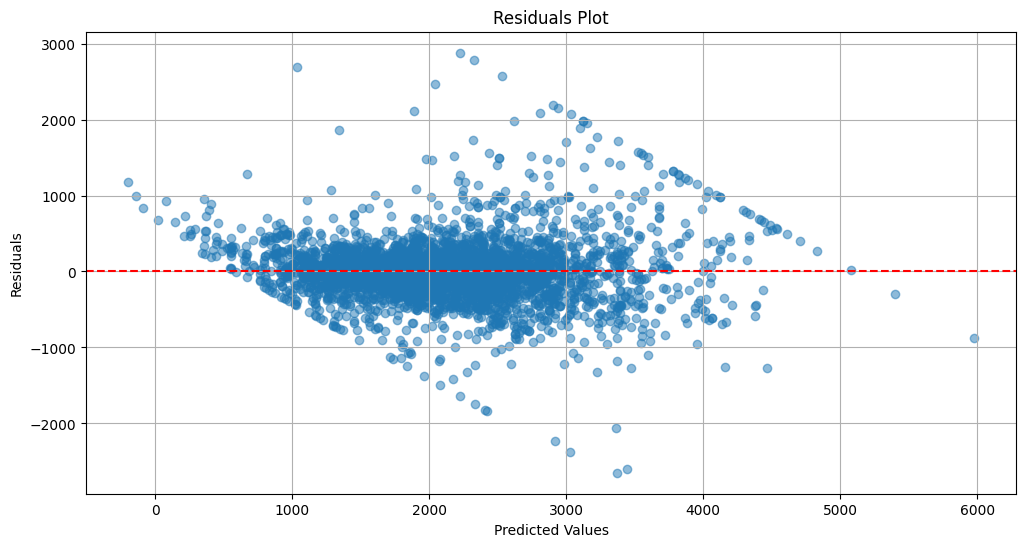

In [41]:
# Visualize Residuals

residuals = y_test - test_predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.savefig('residuals_plot.png') 
plt.show()

In [42]:
# Save the prepared data for modeling

df.to_csv('new_data_predictions.csv', index=False)